# VGG （使用块的网络）
介绍一些常用于设计深层神经网络的启发式概念。

使用块的想法首先出现在牛津大学的[视觉几何组（visual geometry group）](http://www.robots.ox.ac.uk/~vgg/)的VGG网络中。通过使用循环和子程序，可以很容易的在任何现代深度学习框架的代码中实现这些重复的架构。

## （VGG块）
在下面的代码中，定义了一个名为`vgg_block`的函数来实现一个VGG块。

该函数有三个参数，分别对应卷积层的数量`num_convs`、输入通道的数量`in_channels`和输出通道的数量`out_channels`.

In [1]:
import torch 
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

## VGG网络
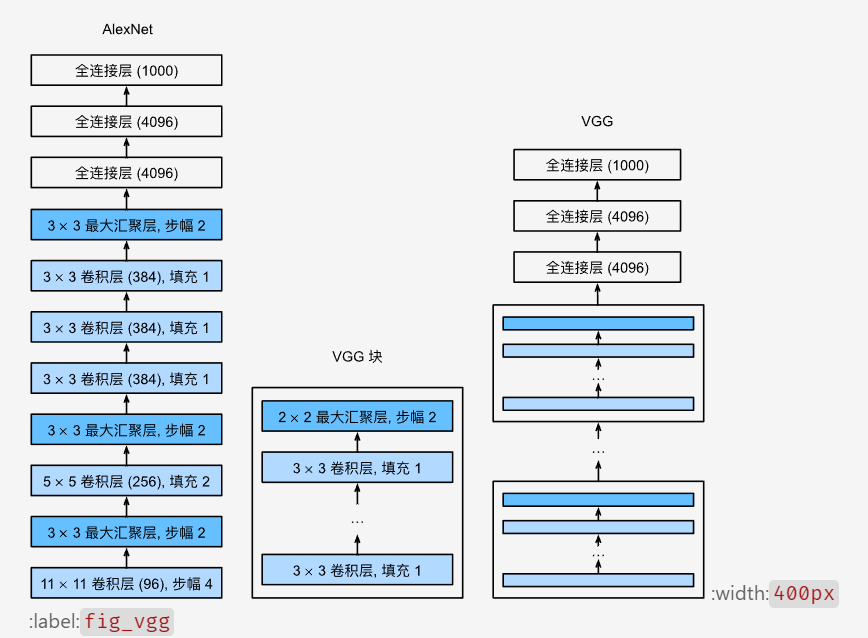

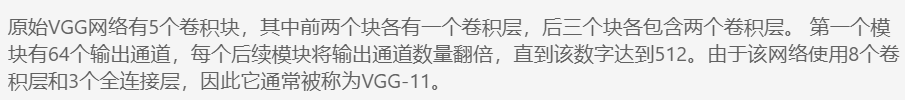

In [2]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

可以通过在`conv_arch`上执行for循环来简单实现。

In [4]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

net = vgg(conv_arch)

接下来构建一个高度和宽度都为224的单通道数据样本，以**观察每个层的输出的形状**。

In [5]:
X = torch.randn(size=(1,1,224,224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, "output shape: \t", X.shape)

Sequential output shape: 	 torch.Size([1, 64, 112, 112])
Sequential output shape: 	 torch.Size([1, 128, 56, 56])
Sequential output shape: 	 torch.Size([1, 256, 28, 28])
Sequential output shape: 	 torch.Size([1, 512, 14, 14])
Sequential output shape: 	 torch.Size([1, 512, 7, 7])
Flatten output shape: 	 torch.Size([1, 25088])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Dropout output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 10])


在每个块的高度和宽度都减半，最终高度和宽度为7。最后展平表示，送入全连接层处理。

## 训练模型
由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够训练Fashion-MNIST数据集

In [6]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

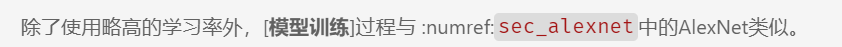

loss 0.183, train acc 0.933, test acc 0.914
1170.8 examples/sec on cuda:0


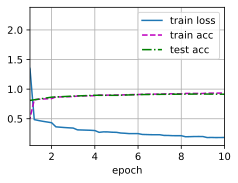

In [7]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

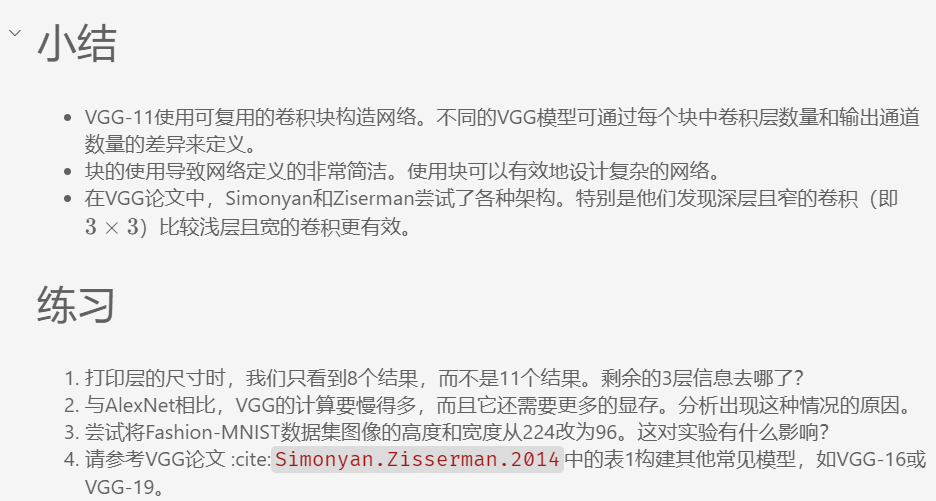